<a href="https://colab.research.google.com/github/miguel-fc/PyTorch-tools/blob/main/m1_training_test_val_CA_pytorch_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


In [2]:
print('Training samples:',len(train_dataset))
print('Test samples:',len(test_dataset))

print('Tensor size:',train_dataset[0][0].size())
print('First 10 digits are:', [train_dataset[i][1] for i in range(10)])

Training samples: 60000
Test samples: 10000
Tensor size: torch.Size([1, 28, 28])
First 10 digits are: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [3]:
print('Min intensity value: ',train_dataset[0][0].min().item())
print('Max intensity value: ',train_dataset[0][0].max().item())

Min intensity value:  0.0
Max intensity value:  1.0


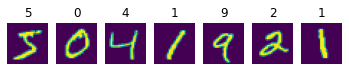

In [4]:
fig,ax = plt.subplots(1,7)
for i in range(7):
    ax[i].imshow(train_dataset[i][0].view(28,28))
    ax[i].set_title(train_dataset[i][1])
    ax[i].axis('off')

In [5]:
class LAutoencoder(nn.Module):
    
    def __init__(self,encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12,encoded_space_dim))
        self.decoder = nn.Sequential(
            nn.Linear(encoded_space_dim, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28),
            nn.Sigmoid() )
        
    def forward(self, x):
            latent = self.encoder(x)
            x = self.decoder(latent)
            return x,latent

In [6]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 2

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
model = LAutoencoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': model.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')
# Move both the encoder and the decoder to the selected device
model.to(device)

Selected device: cuda


LAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [7]:
# num_epochs = 10
# criterion = nn.MSELoss()

# for epoch in range(num_epochs):
#     for data in train_loader:
#         img, labels = data
#         img = img.view(img.size(0), -1).cuda()  
               
#         output,latent = model(img)
#         loss = criterion(output, img)
       
#         loss.backward()
#         optim.step()
#         optim.zero_grad()
    
#     print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.data.item()}')


In [8]:
### Training function
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    model.train()
    # decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for data in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        img, labels = data
        img = img.view(img.size(0), -1).to(device)  
        # Encode and Decode data
        output,latent = model(img)
        loss = loss_fn(output, img)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t train loss per batch: %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [9]:
### Testing function
def test_epoch(model, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    model.eval()
    # decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for  data in dataloader:
            img, labels = data
            img = img.view(img.size(0), -1).to(device) 
            # Encode and Decode data
            output, latent = model(img)
            # Append the network output and the original image to the lists
            conc_out.append(output.cpu())
            conc_label.append(img.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [10]:
# def plot_ae_outputs(model,n=10):
#     plt.figure(figsize=(16,4.5))
#     targets = test_dataset.targets.numpy()
#     t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
#     for i in range(n):
#       ax = plt.subplot(2,n,i+1)
#       img = test_dataset[t_idx[i]][0]
#       img = img.view(img.size(0), -1).cuda()  
#       model.eval()
#       with torch.no_grad():
#          rec_img,_  = model(img)
#         #  print("pepe",img.shape,rec_img.shape)
#       plt.imshow(img.cpu().reshape(28,28).numpy(), cmap='gist_gray')
#       ax.get_xaxis().set_visible(False)
#       ax.get_yaxis().set_visible(False)  
#       if i == n//2:
#         ax.set_title('Original images')
#       ax = plt.subplot(2, n, i + 1 + n)
#       plt.imshow(rec_img.cpu().reshape(28,28).numpy(), cmap='gist_gray')  
#       ax.get_xaxis().set_visible(False)
#       ax.get_yaxis().set_visible(False)  
#       if i == n//2:
#          ax.set_title('Reconstructed images')
#     plt.show()   

In [11]:
num_epochs = 100
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss =train_epoch(model,device,train_loader,loss_fn,optim)
  val_loss = test_epoch(model,device,test_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)

EPOCH 1/100 	 train loss 0.08178307861089706 	 val loss 0.06184732913970947
EPOCH 2/100 	 train loss 0.057386089116334915 	 val loss 0.05526144802570343
EPOCH 3/100 	 train loss 0.05428498983383179 	 val loss 0.053318094462156296
EPOCH 4/100 	 train loss 0.05234924331307411 	 val loss 0.051519978791475296
EPOCH 5/100 	 train loss 0.05094963312149048 	 val loss 0.05036359280347824
EPOCH 6/100 	 train loss 0.04999948665499687 	 val loss 0.04943390563130379
EPOCH 7/100 	 train loss 0.04911447688937187 	 val loss 0.048442527651786804
EPOCH 8/100 	 train loss 0.04826189577579498 	 val loss 0.04763972759246826
EPOCH 9/100 	 train loss 0.04759351164102554 	 val loss 0.04689694568514824
EPOCH 10/100 	 train loss 0.04689483344554901 	 val loss 0.04630354791879654
EPOCH 11/100 	 train loss 0.046261705458164215 	 val loss 0.04570843651890755
EPOCH 12/100 	 train loss 0.04571967571973801 	 val loss 0.04527406767010689
EPOCH 13/100 	 train loss 0.04520149528980255 	 val loss 0.0447191558778286
EPOC

In [12]:
0.0546257868409156

0.0546257868409156

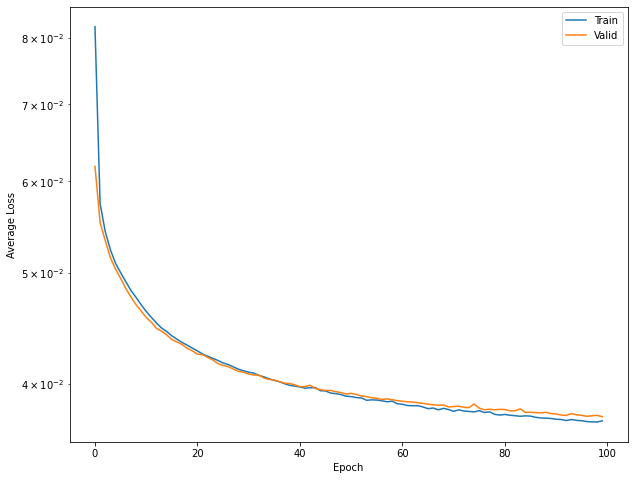

In [13]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

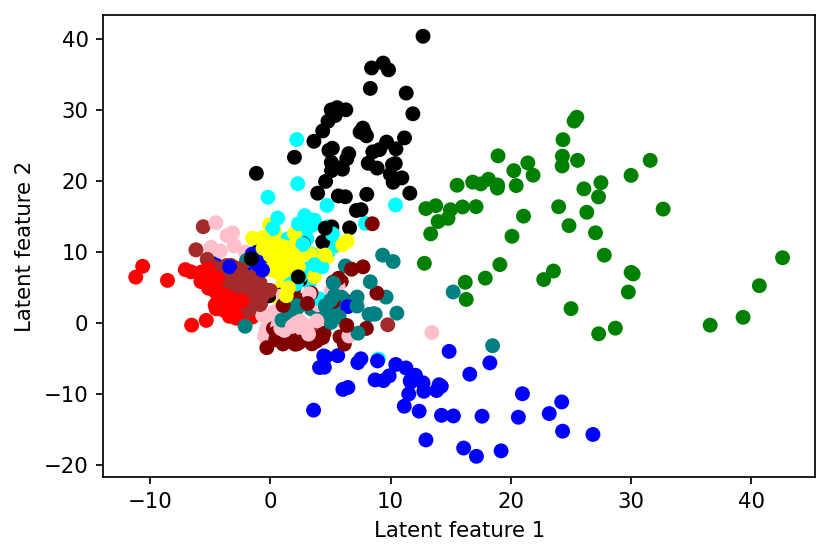

In [14]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
for data in dataloader:
        img, labels = data
        img = img.view(img.size(0), -1)    
        model.cpu()    
        _,latent = model(img)
        break

d = {0: 'red', 1: "green", 2: "blue", 3: "maroon", 4: "yellow", 
     5: "pink", 6: "brown", 7: "black", 8: "teal", 9: "aqua"}

colors = []       
for e in labels.numpy():
    colors.append(d[e])

fig = plt.figure(dpi=153)
ax = fig.add_subplot(111)
ax.set_xlabel('Latent feature 1')
ax.set_ylabel('Latent feature 2')

ax.scatter(latent[:,0].detach().numpy(), latent[:,1].detach().numpy(), 
           c=list(colors))

In [15]:
def plot_ae_outputs(model,device,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0]
      img = img.view(img.size(0), -1).to(device) 
      model.eval().to(device)
      with torch.no_grad():
         rec_img,_  = model(img)
        #  print("pepe",img.shape,rec_img.shape)
      plt.imshow(img.cpu().reshape(28,28).numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().reshape(28,28).numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  

In [16]:
# model.to(device)

In [17]:
# plot_ae_outputs(model,device,n=10)

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!pwd

/content


In [20]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [21]:
!ls

'100K proposal draft.gdoc'
 120-overlap-tiles-Ferrobot.npy
 cell-rvae-iter100-control-and-induced-4-8-24-48-72.tar
 cell-rvae-iter200-control-and-induced-4-8-24-48-72.tar
 cells-organelles-trained-models
 cell-w-rvae-iter100-control-and-induced-4-8-24-48-72.tar
 cell-w-rvae-iter200-control-and-induced-4-8-24-48-72.tar
'CNMS proposal.gdoc'
'Colab Notebooks'
 control24_gfp_masks.npy
 control48_gfp_masks.npy
 control4_gfp_masks.npy
 control72_gfp_masks.npy
 control8_gfp_masks.npy
 cutting-cells-rvae.tar
 cutting-setCBsrvae.tar
 CV-Fuentes-Cabrera.pdf
 cyto
 E_coli
 feb10-ecoli.npy
 ferrobot-videos
 gt_checking_overlap.npy
 Humberto-CNMS-proposal.gdoc
 IA-cursillo.gdoc
 images_np.npy
 indiv-CB-masks-control-and-induced.npy
 indiv_masks.npy
 induced24_dsred_masks.npy
 induced24_gfp_masks.npy
 induced48_gfp_masks.npy
 induced4_gfp_masks.npy
 induced72_gfp_masks.npy
 induced8_gfp_masks.npy
 interpolation.tar.gz
 j-cell-rvae-iter100-control-and-induced-4-8-24-48-72.tar
 j-cell-w-rvae-iter100-c

In [22]:
filepath = '/content/drive/MyDrive/la.pth'

In [23]:
torch.save(model.state_dict(),filepath)

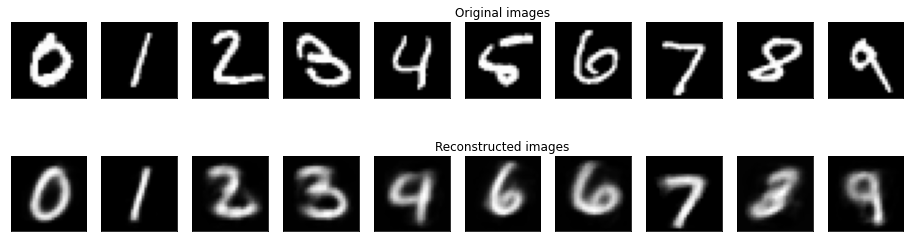

In [24]:
model.load_state_dict(torch.load(filepath))
plot_ae_outputs(model,device,n=10)

In [25]:
# state = {
#     'epoch': epoch,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optim.state_dict(),
#     'loss': loss_fn,
# }
# torch.save(state, filepath)

In [26]:
# num_epochs = 2
# diz_loss = {'train_loss':[],'val_loss':[]}
# for epoch in range(num_epochs):
#   # print (epoch)
#   train_loss =train_epoch(model,device,train_loader,loss_fn,optim)
#   val_loss = test_epoch(model,device,test_loader,loss_fn)
#   print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
#   diz_loss['train_loss'].append(train_loss)
#   diz_loss['val_loss'].append(val_loss)

In [27]:
# checkpoint = torch.load(filepath)
# model.load_state_dict(checkpoint['model_state_dict'])
# optim.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss_fn = checkpoint['loss']